In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12, 6)})
import warnings
import time
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('test_data.csv')

In [3]:
# simple watch data
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [4]:
# look about size of data
df.shape

(122097, 10)

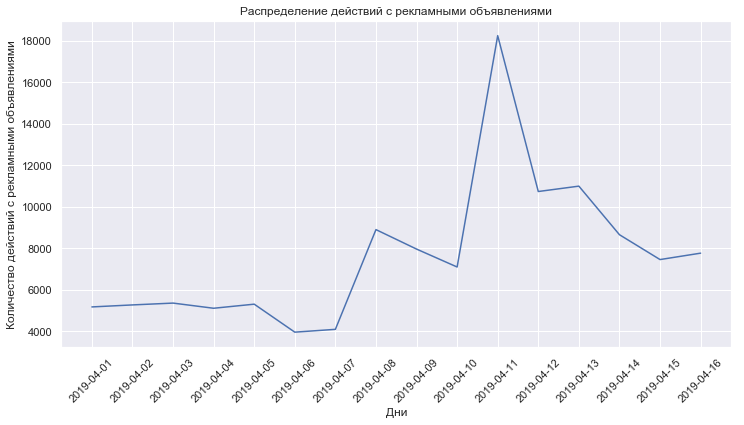

In [5]:
# look distribution amount of events by day 
day_events = df.groupby('date', as_index=False).agg({'event':'count'}).rename(columns=
        {'date':'Дни', 'event':'Количество действий с рекламными объявлениями'})
sns.set(rc={'figure.figsize':(12, 6)})
plt.title('Распределение действий с рекламными объявлениями')
plt.xticks(rotation=45)
sns.lineplot(x=day_events['Дни'],y=day_events['Количество действий с рекламными объявлениями'], data=day_events)

In [6]:
# возможны несколько подходов к автоматическому детектированию
# выполняем preprocessing данных - на выходе массив показателей за необходимый интервал (час,5 мин или другое)
# далее необходмо среди них найти аномалии
# 1. Найти выбросы c помощью статистики
# 2. Возможно использования оконных алгоритмов, вычисляющих корреляции

In [7]:
# для удобства работы и формирования нужных интервалов времени преобразуем timestamp в full date
df['day'] = df.date
df['date'] = pd.to_datetime(df.time, unit='s')

In [8]:
# проверяем все ли получилось
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,day
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08 17:22:25,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12 21:10:58,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16 08:16:41,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09 15:07:59,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11 07:11:57,2019-04-11


In [9]:
# группируем данные по дате и считаем количество событий
ad_events_data = df.groupby('date', as_index=False).agg({'event':'count'})
ad_events_data.set_index('date', inplace=True)

In [10]:
# проверяем себя
ad_events_data.head()

,event
date,
2019-04-01 00:00:48,1
2019-04-01 00:01:03,1
2019-04-01 00:01:09,1
2019-04-01 00:01:19,1
2019-04-01 00:01:37,1


    # Группируем данные за некоторый диапазон (N минут, час, N часов и тд)

In [35]:
# группируем данные на интервале за 5 минут
ad_events_data_by_period = ad_events_data.resample('5T').sum()

In [36]:
# так мы не знаем какой вид у распределения количества событий по дням применим метод интерквартильного размаха
# вычислим 25 и 75 перцентили, интерквартильный размах
q25, q75 = ad_events_data_by_period.event.quantile(0.25), ad_events_data_by_period.event.quantile(0.75)
iqr = q75 - q25

In [41]:
# стандартный порог для определения выбросов полтора интерквартильного размаха
cut_off = iqr * 3
# вычисляем нижний и верхний пороги для данных
lower, upper = q25 - cut_off, q75 + cut_off
# для определения экстремальных выбросов можно использовать величину порога 3 * iqr

In [42]:
# фильтруем данные и создем новую колонку в данных 'anomaly' 
# нас интересуют выбросы большие чем upper
ad_events_data_by_period['anomaly'] = ad_events_data_by_period.event > upper

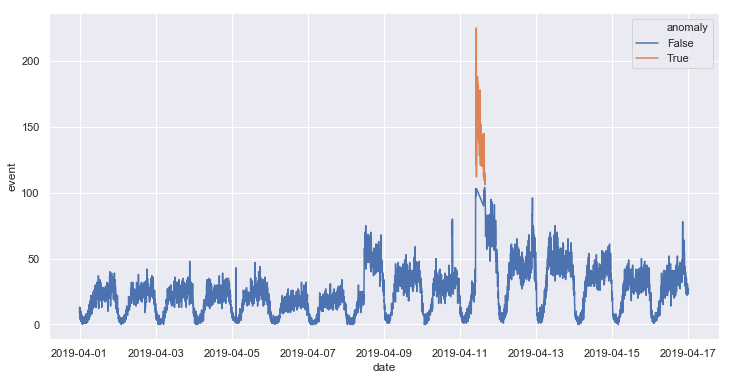

In [44]:
# построим график event by interval  и покрасим те части где зафиксированы аномалии
sns.lineplot(x=ad_events_data_by_period.index, y='event', data=ad_events_data_by_period, hue='anomaly')

In [56]:
# выводим даты аномальных показателей
anomaly_events = ad_events_data_by_period[ad_events_data_by_period.anomaly == True]
anomaly_events.head()

,event,anomaly
date,,
2019-04-11 09:55:00,173,True
2019-04-11 10:05:00,121,True
2019-04-11 10:10:00,181,True
2019-04-11 10:15:00,225,True
2019-04-11 10:20:00,112,True


In [74]:
# посмотрим на распределение событий по типу
# добавим к типу событий еще одну группирующую переменную
events_data = df.pivot_table(index='date',
              columns=['event', 'ad_cost_type'],
               values='time',
               aggfunc='count',
               fill_value=0).reset_index()
events_data.head()

event                       date click     report     view    
ad_cost_type                       CPC CPM    CPC CPM  CPC CPM
0            2019-04-01 00:00:48     0   1      0   0    0   0
1            2019-04-01 00:01:03     0   0      0   0    1   0
2            2019-04-01 00:01:09     0   0      0   0    0   1
3            2019-04-01 00:01:19     0   0      0   0    1   0
4            2019-04-01 00:01:37     0   0      0   0    1   0

In [75]:
# установим в качестве индекса date
events_data.set_index('date', inplace=True)

In [76]:
events_data.head()

event               click     report     view    
ad_cost_type          CPC CPM    CPC CPM  CPC CPM
date                                             
2019-04-01 00:00:48     0   1      0   0    0   0
2019-04-01 00:01:03     0   0      0   0    1   0
2019-04-01 00:01:09     0   0      0   0    0   1
2019-04-01 00:01:19     0   0      0   0    1   0
2019-04-01 00:01:37     0   0      0   0    1   0

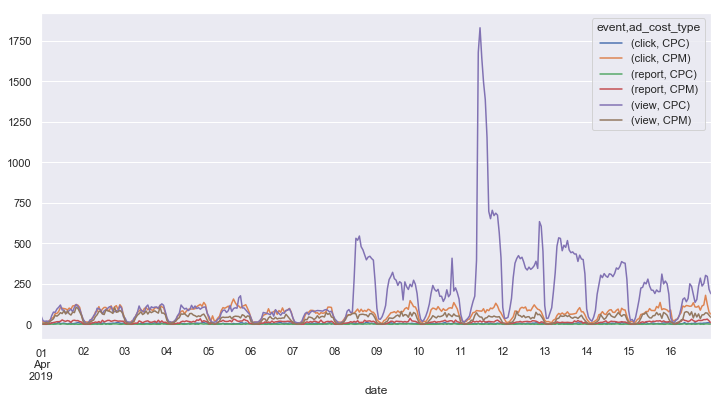

In [77]:
# аггрегируем данные по интревалу (1час) и строим график
# аномальные показатели наблюдаются у событий типа 'view'
events_data.resample('1H').sum().plot()

In [ ]:
# из графика видно, что аномалии наблюдаются на событиях типа 'view' при типе рекламы CPC

In [87]:
# посмотрим на количество событий для каждого агенства
events_data_agency = df.pivot_table(index='agency_union_id',
              columns=['event'],
               values='time',
               aggfunc='count',
               fill_value=0).reset_index()
events_data_agency.head()

event,agency_union_id,click,report,view
0,agency_100051,1,0,0
1,agency_100606,2,0,0
2,agency_10062,1,0,8
3,agency_100686,1,0,0
4,agency_100773,2,0,0


In [89]:
# выясним у какого агенства максимальное количество показов
anomaly_agency = events_data_agency.agency_union_id\
            [events_data_agency.view == events_data_agency.view.max()].item()

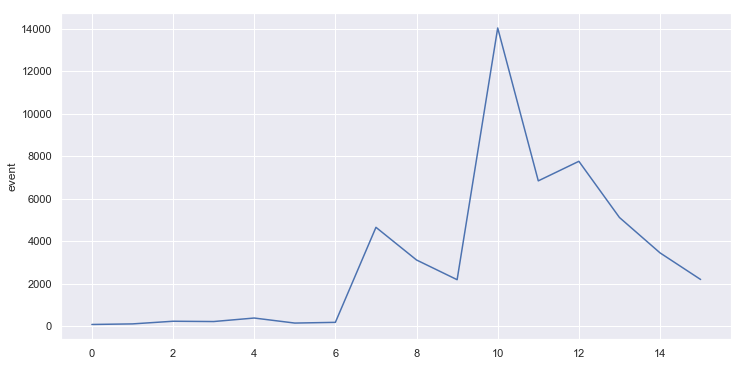

In [101]:
# посмотрим на распределение событий аномального агенства
events_anomaly_agency = df[df.agency_union_id == anomaly_agency].groupby('day', as_index=False).agg({'event':'count'})
sns.lineplot(x=events_anomaly_agency.index, y='event', data=events_anomaly_agency)

In [102]:
# получается, что все аномальные события - это события от агенства 'agency_2' типа 'view' тип рекламы CPC
# очень похоже на вирусный кликбейт